In [1]:
import os
import time

import utils

import numpy as np

from evo.core import metrics

import copy
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib tk


import multiprocessing as mp
from functools import partial
import numpy as np
import itertools


import pprint

from scipy.spatial.transform import Rotation as R

In [2]:
from evo.tools.file_interface import read_tum_trajectory_file
from evo.core import sync

from evo.tools import plot

In [3]:
device='AVP' # 'Quest' # 'AVP'
trialName = 'LocalTransform'
root_dir = f"../CalibData/{device}/{trialName}"

os.chdir(root_dir)
root_dir = "."

## Load trajectories

In [4]:
def plot_trajectory(traj_est, traj_ref, benchmark=None, trajectory=None, trial=None):
    fig = plt.figure(figsize=[5,5])

    traj_est_aligned = copy.deepcopy(traj_est)
    traj_ref_aligned = copy.deepcopy(traj_ref)
    
    traj_by_label = {
        "estimate": traj_est_aligned,
        "reference": traj_ref_aligned
    }

    plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)


    ax = plt.gca()
    
    traj_est_aligned.downsample(int(0.05*traj_est_aligned.num_poses))
    traj_ref_aligned.downsample(int(0.05*traj_ref_aligned.num_poses))
    traj_ref_aligned, traj_est_aligned = sync.associate_trajectories(traj_ref_aligned, traj_est_aligned, max_diff=0.1)

    
    plot.draw_correspondence_edges(ax=ax, traj_1=traj_est_aligned,
                                    traj_2=traj_ref_aligned,
                                    plot_mode=plot.PlotMode.xyz, style = '-',
                                    color="black", alpha = 0.2)
    
    plot.draw_coordinate_axes(ax=ax, traj=traj_est_aligned,
                         plot_mode=plot.PlotMode.xyz, marker_scale = 0.01,
                         x_color="r", y_color="g", z_color="b")
    
    plot.draw_coordinate_axes(ax=ax, traj=traj_ref_aligned,
                         plot_mode=plot.PlotMode.xyz, marker_scale = 0.01,
                         x_color="r", y_color="g", z_color="b") 
    #fig.savefig('./figures/{}-{}-{}-trajectory.png'.format(benchmark, trajectory, trial))



In [5]:
def align_trajectory(traj_ref, traj_est, offset):
    traj_est_aligned = copy.deepcopy(traj_est)
    traj_ref_aligned = copy.deepcopy(traj_ref)
    traj_ref_aligned, traj_est_aligned = sync.associate_trajectories(traj_ref_aligned, traj_est_aligned, 
                                                                  max_diff=0.01, 
                                                                  offset_2=offset)
    
    traj_est_aligned.align(traj_ref_aligned, correct_scale=False, correct_only_scale=False)#, n=n)
    return traj_ref_aligned, traj_est_aligned

In [6]:
def quaternion_to_rotation_matrix(quaternion):

    r = R.from_quat(quaternion)
    return r.as_matrix()

def compute_average_transformation_matrix(traj_pair_list):
    transformation_matrices_list = []

    for i, traj_pair in enumerate(traj_pair_list):
        traj_gt_cp, traj_xr_cp = traj_pair[0], traj_pair[1]

        A_quaternions = traj_gt_cp.orientations_quat_wxyz
        B_quaternions = traj_xr_cp.orientations_quat_wxyz

        n = A_quaternions.shape[0]
        transformation_matrices = np.zeros((n, 3, 3))
        
        for j in range(n):
            # Convert quaternions to rotation matrices
            R_A = quaternion_to_rotation_matrix(A_quaternions[i])
            R_B = quaternion_to_rotation_matrix(B_quaternions[i])
            
            # Compute the transformation matrix for each pair
            transformation_matrices[j] = R_B @ np.linalg.inv(R_A)

        transformation_matrices_list.append(transformation_matrices)     
    
    all_transformation_matrices = np.concatenate(transformation_matrices_list, axis=0)
    print(all_transformation_matrices.shape)
    # Average the transformation matrices
    average_transformation_matrix = np.mean(all_transformation_matrices, axis=0)
    
    return average_transformation_matrix, all_transformation_matrices

In [7]:
def prepare_traj_pair(traj_gt, traj_xr):
    traj_gt = utils.check_monotionic_increaseing(traj_gt)
    traj_gt = utils.check_gt_abnormal_traj(traj_gt, speed_threshold=3)
    traj_xr = utils.check_monotionic_increaseing(traj_xr, type='xr')

    traj_gt_cp, traj_xr_cp = align_trajectory(traj_gt, traj_xr, offset=0)
    plot_trajectory(traj_xr_cp, traj_gt_cp, benchmark=None, trajectory=None, trial=None)

    return (traj_gt_cp, traj_xr_cp)

gt - found 0 non-monotonic increasing rows
gt - found 0 abnormal_step_rows
xr - found 408 non-monotonic increasing rows
gt - found 0 non-monotonic increasing rows
gt - found 0 abnormal_step_rows
xr - found 294 non-monotonic increasing rows


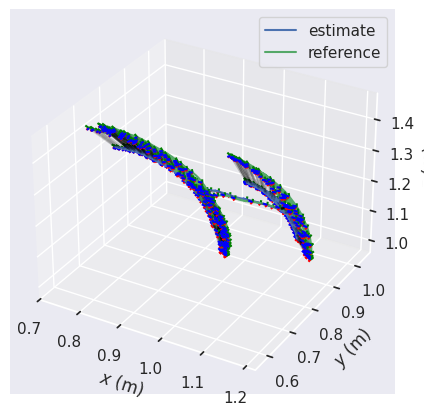

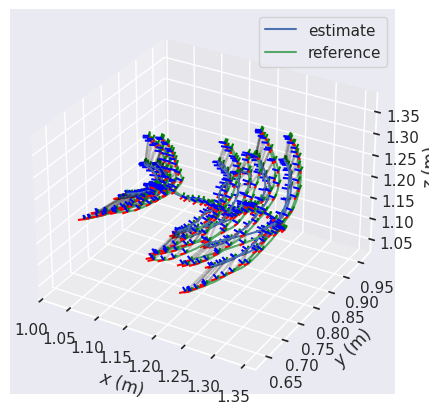

In [8]:
traj_pair_list = []

traj_gt = read_tum_trajectory_file("./YZ/gt.txt")
traj_xr = read_tum_trajectory_file("./YZ/xr.txt")
traj_pair_list.append(prepare_traj_pair(traj_gt, traj_xr))
traj_gt = read_tum_trajectory_file("./XZ/gt.txt")
traj_xr = read_tum_trajectory_file("./XZ/xr.txt")
traj_pair_list.append(prepare_traj_pair(traj_gt, traj_xr))

In [9]:
# # 2. Get transformation matrix
# A_quaternions = traj_gt_cp.orientations_quat_wxyz
# B_quaternions = traj_xr_cp.orientations_quat_wxyz
average_transformation_matrix, all_transformation_matrices = compute_average_transformation_matrix(traj_pair_list)
print("Average Transformation Matrix from A to B:")
print(average_transformation_matrix)

(10506, 3, 3)
Average Transformation Matrix from A to B:
[[ 0.99625924 -0.05535767 -0.0371308 ]
 [ 0.05575718  0.99683364  0.01344899]
 [ 0.03697038 -0.01615976  0.99905235]]


In [10]:
rotation_transform = np.zeros((4,4))
rotation_transform[0:3,0:3] = average_transformation_matrix
rotation_transform[3,3] = 1
rotation_transform

array([[ 0.99625924, -0.05535767, -0.0371308 ,  0.        ],
       [ 0.05575718,  0.99683364,  0.01344899,  0.        ],
       [ 0.03697038, -0.01615976,  0.99905235,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

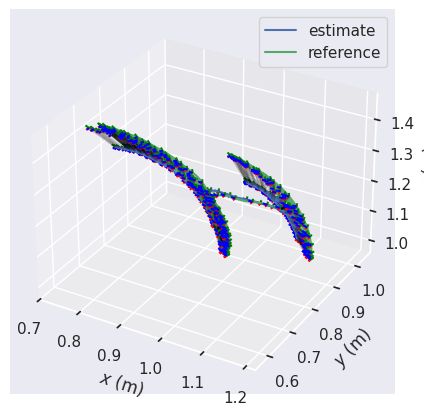

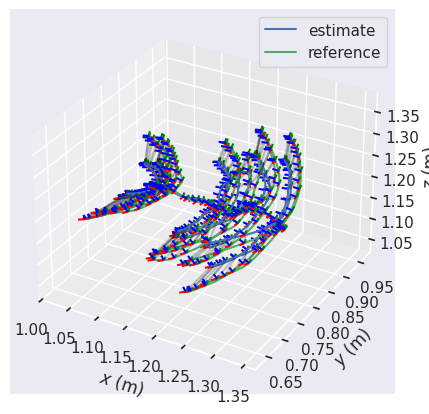

In [11]:
for i, traj_pair in enumerate(traj_pair_list):
    traj_gt_cp, traj_xr_cp = traj_pair[0], traj_pair[1]
    traj_gt_align = copy.deepcopy(traj_gt_cp)
    traj_gt_align.transform(t=rotation_transform, right_mul=True, propagate=False)
    plot_trajectory(traj_xr_cp, traj_gt_align, benchmark=None, trajectory=None, trial=None)

In [12]:
def perform_yz_transform(traj_gt, rotation_transform, y, z):
    transformation_matrix_test = copy.deepcopy(rotation_transform)
    transformation_matrix_test[1,3] = y
    transformation_matrix_test[2,3] = z

    traj_gt_align_test = copy.deepcopy(traj_gt)
    traj_gt_align_test.transform(t=transformation_matrix_test, right_mul=True, propagate=False)
    return traj_gt_align_test, transformation_matrix_test

def perform_xyz_transform(traj_gt, rotation_transform, x, y, z):
    transformation_matrix_test = copy.deepcopy(rotation_transform)
    transformation_matrix_test[0,3] = x
    transformation_matrix_test[1,3] = y
    transformation_matrix_test[2,3] = z

    traj_gt_align_test = copy.deepcopy(traj_gt)
    traj_gt_align_test.transform(t=transformation_matrix_test, right_mul=True, propagate=False)
    return traj_gt_align_test, transformation_matrix_test

In [13]:
def perform_xyz_transform_ape(x, y, z, traj_pair_list, rotation_transform):
    transformation_matrix_test = copy.deepcopy(rotation_transform)
    transformation_matrix_test[0,3] = x
    transformation_matrix_test[1,3] = y
    transformation_matrix_test[2,3] = z

    # traj_gt_align_test = copy.deepcopy(traj_gt)
    # traj_gt_align_test.transform(t=transformation_matrix_test, right_mul=True, propagate=False)

    # traj_gt_align_test, traj_xr_cp = align_trajectory(traj_gt_align_test, traj_xr, offset=0)
    # ape_metric = utils.calculate_APE(traj_xr_cp, traj_gt_align_test, est_offset=0)
    ape_list = []
    total_length = 0
    for i, traj_pair in enumerate(traj_pair_list):
        traj_gt_cp, traj_xr_cp = traj_pair[0], traj_pair[1]
        traj_gt_align = copy.deepcopy(traj_gt_cp)
        traj_gt_align.transform(t=transformation_matrix_test, right_mul=True, propagate=False)
        traj_gt_align, traj_xr_cp = align_trajectory(traj_gt_align, traj_xr_cp, offset=0)
        ape_metric = utils.calculate_APE(traj_xr_cp, traj_gt_align, est_offset=0)
        ape = ape_metric.get_statistic(metrics.StatisticsType.rmse)
        ape_list.append(ape*traj_gt_cp.num_poses)
        total_length += traj_gt_cp.num_poses

    avg_ape = np.sum(ape_list)/total_length
    return avg_ape#ape_metric.get_statistic(metrics.StatisticsType.rmse)


def parallel_compute(x_array, y_array, z_array, traj_pair_list, rotation_transform):
    # Create a partial function with the constant arguments
    partial_compute = partial(perform_xyz_transform_ape, traj_pair_list=traj_pair_list, rotation_transform=rotation_transform)
    
    # # Combine the individual x, y, z lists into a list of tuples
    # inputs = list(zip(x_list, y_list, z_list))
    # Generate all combinations of x, y, z using itertools.product
    inputs = list(itertools.product(x_array, y_array, z_array))
    
    with mp.Pool(mp.cpu_count()) as pool:
        # Use starmap with the partial function
        results = pool.starmap(partial_compute, inputs)
    
    return results

In [14]:
resolution = 11
x_start, x_end = 0.01, 0.03
y_start, y_end = -0.04, -0.02
z_start, z_end = 0.09, 0.11

In [15]:
#error_matrix = np.ones((resolution,resolution))
x_array = np.linspace(x_start,x_end,resolution)
y_array = np.linspace(y_start,y_end,resolution)
z_array = np.linspace(z_start,z_end,resolution)

# Perform parallel computation
results = parallel_compute(x_array, y_array, z_array, traj_pair_list, rotation_transform)

# Print the results
# for (x, y, z), result in zip(itertools.product(x_array, y_array, z_array), results):
#     print(f"compute({x}, {y}, {z}, {constant1}, {constant2}) = {result}")


In [16]:
# Find the minimum result and its corresponding (x, y, z) values
inputs = list(itertools.product(x_array, y_array, z_array))
min_index = np.argmin(results)
min_value = results[min_index]
min_combination = inputs[min_index]
# Print the result
print(f"The combination of x, y, z that gives the minimum result is: {min_combination} with a value of {min_value}")

The combination of x, y, z that gives the minimum result is: (np.float64(0.022), np.float64(-0.026000000000000002), np.float64(0.104)) with a value of 0.0033060324870165755


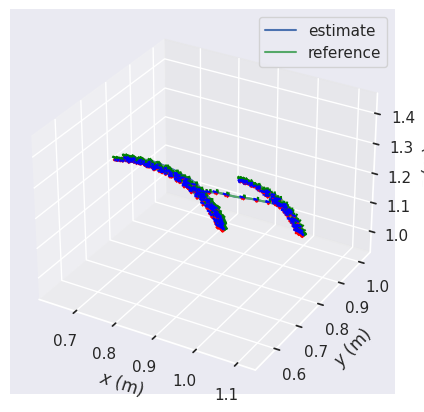

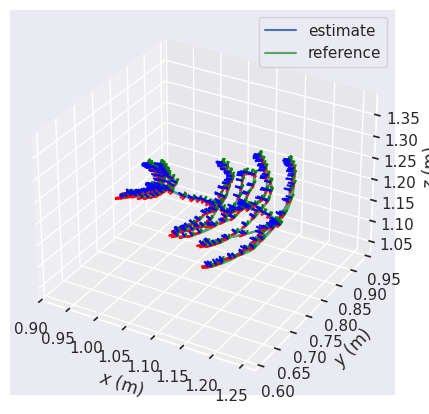

In [17]:
for i, traj_pair in enumerate(traj_pair_list):
    traj_gt_cp, traj_xr_cp = traj_pair[0], traj_pair[1]
    traj_gt_align = copy.deepcopy(traj_gt_cp)
    traj_gt_align.transform(t=rotation_transform, right_mul=True, propagate=False)
    #plot_trajectory(traj_xr_cp, traj_gt_align, benchmark=None, trajectory=None, trial=None)

    traj_gt_align_test, transformation_matrix_test = perform_xyz_transform(traj_gt_cp, rotation_transform, 
                                                                        min_combination[0], min_combination[1], min_combination[2])
    traj_gt_align_test, traj_xr_cp = align_trajectory(traj_gt_align_test, traj_xr_cp, offset=0)

    plot_trajectory(traj_xr_cp, traj_gt_align_test, benchmark=None, trajectory=None, trial=None)

In [18]:
transformation_matrix_test

array([[ 0.99625924, -0.05535767, -0.0371308 ,  0.022     ],
       [ 0.05575718,  0.99683364,  0.01344899, -0.026     ],
       [ 0.03697038, -0.01615976,  0.99905235,  0.104     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

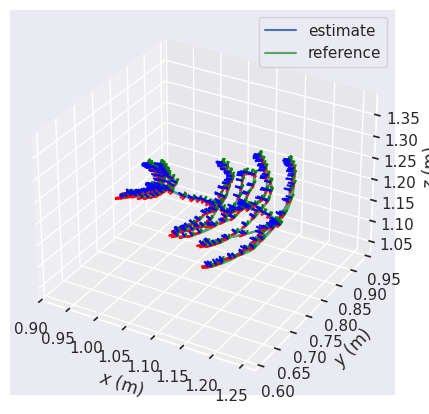

In [19]:
plot_trajectory(traj_xr_cp, traj_gt_align_test, benchmark=None, trajectory=None, trial=None)

In [20]:
rpe = utils.calculate_RE(traj_xr_cp, traj_gt_align_test, est_offset=0)
np.mean(rpe.error)

np.float64(0.002185015878225453)

In [21]:
ape_metric = utils.calculate_APE(traj_xr_cp, traj_gt_align_test, est_offset=0)

In [22]:
ape_metric.get_statistic(metrics.StatisticsType.rmse)

0.002855954668296212

In [23]:
result_np = np.array(results).reshape((resolution, resolution, resolution))

In [24]:
# Find the indices of the given number
x_index = np.where(x_array == min_combination[0])[0][0]
y_index = np.where(y_array == min_combination[1])[0][0]
z_index = np.where(z_array == min_combination[2])[0][0]


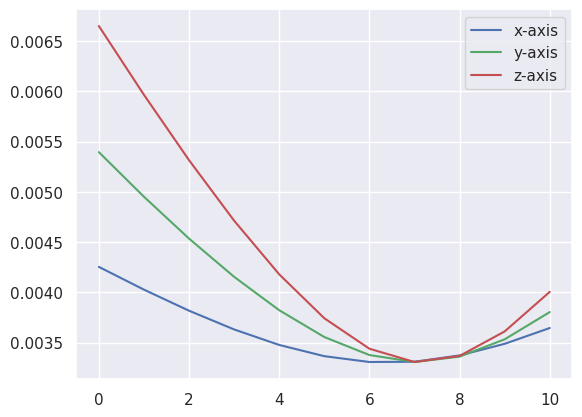

In [25]:
plt.figure()
plt.plot(result_np[:, y_index, z_index], label="x-axis")
plt.plot(result_np[x_index, :, z_index], label="y-axis")
plt.plot(result_np[x_index, y_index, :], label="z-axis")
plt.legend()
plt.show()